# Modelo MLP para Previsão de Preços de Criptomoedas

## Importação das Bibliotecas

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, PReLU
from tensorflow.keras.optimizers import Adam, Adamax, AdamW, Lion,RMSprop
import joblib

## PASSO 1: Carregar e Preparar os Dados

**Objetivo:** Ler o arquivo CSV e garantir que ele esteja em ordem.

In [29]:
# Carrega os dados do arquivo CSV
df = pd.read_csv(r"C:\Users\abgad\Downloads\SOLUSDT_1h_data.csv")

# Garante que a coluna 'timestamp' seja do tipo data e ordena os dados
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df = df.reset_index(drop=True)

# Aplicar transformação logarítmica nas colunas 'close' e 'volume' para lidar com outliers
# Usamos np.log1p que calcula log(1+x) para lidar com valores que podem ser zero ou próximos de zero
cols_to_log = ['close', 'volume']
for col in cols_to_log:
    df[col] = np.log1p(df[col])

# Remove colunas com nomes "Unnamed".
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

print(f"Dados carregados: {df.shape[0]} registros.")
print(df.head())

Dados carregados: 17520 registros.
            timestamp   open   high    low     close     volume
0 2023-07-20 16:00:00  25.69  25.77  25.21  3.277522  12.935543
1 2023-07-20 17:00:00  25.52  25.67  25.40  3.279783  11.919740
2 2023-07-20 18:00:00  25.58  25.58  25.25  3.273364  12.173379
3 2023-07-20 19:00:00  25.40  25.52  25.27  3.272985  11.862243
4 2023-07-20 20:00:00  25.40  25.40  25.03  3.266904  12.382280


## PASSO 2: Preparar os Dados para o Modelo

**Objetivo:** Transformar os dados brutos em um formato que a rede neural entenda (features e target).

In [30]:
# --- Calculo dos Indicadores ---
# Calcula as variações percentuais de 'close' e 'volume'
df['close_pct'] = df['close'].pct_change()
df['volume_pct'] = df['volume'].pct_change()

# Calcula a média móvel simples de 10 e 30 períodos para 'close'
df['sma_10'] = df['close'].rolling(window=10).mean()
df['sma_30'] = df['close'].rolling(window=30).mean()

# Calcula o Índice de Força Relativa (RSI) de 14 períodos
def rsi(series, period=14):
    gain = (series.where(series > 0, 0)).rolling(window=period).mean()
    loss = (-series.where(series < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))
df['rsi_7'] = rsi(df['close'], period=7)
df['rsi_14'] = rsi(df['close'], period=14)
df['rsi_21'] = rsi(df['close'], period=21)

# Calcula o MACD
def macd(series, short_window=12, long_window=26, signal_window=9):
    exp1 = series.ewm(span=short_window, adjust=False).mean()
    exp2 = series.ewm(span=long_window, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line
df['macd'], df['macd_signal'] = macd(df['close'])

# Calcula o Bollinger Bands
def bollinger_bands(series, window=20, num_std_dev=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band
df['bb_upper'], df['bb_lower'] = bollinger_bands(df['close'])

# Calcula o Average True Range (ATR)
def atr(df, window=14):
    high_low = df['high'] - df['low']
    high_prev_close = abs(df['high'] - df['close'].shift())
    low_prev_close = abs(df['low'] - df['close'].shift())
    tr = pd.DataFrame({'hl': high_low, 'hpc': high_prev_close, 'lpc': low_prev_close}).max(axis=1)
    atr_val = tr.rolling(window=window).mean()
    return atr_val
df['atr_14'] = atr(df, window=14) # Adicionando ATR de 14 períodos

# Calcula o Stochastic Oscillator (%K e %D)
def stochastic_oscillator(df, k_window=14, d_window=3):
    lowest_low = df['low'].rolling(window=k_window).min()
    highest_high = df['high'].rolling(window=k_window).max()
    k_percent = ((df['close'] - lowest_low) / (highest_high - lowest_low)) * 100
    d_percent = k_percent.rolling(window=d_window).mean()
    return k_percent, d_percent
df['so_k'] = stochastic_oscillator(df)[0] # %K do Stochastic
df['so_d'] = stochastic_oscillator(df)[1] # %D (média de %K) do Stochastic

# Calcula o Williams %R
def williams_percent_r(df, window=14):
    lowest_low = df['low'].rolling(window=window).min()
    highest_high = df['high'].rolling(window=window).max()
    wpr = ((highest_high - df['close']) / (highest_high - lowest_low)) * -100
    return wpr
df['wpr_14'] = williams_percent_r(df, window=14) # Williams %R de 14 períodos

# Calcula o On-Balance Volume (OBV)
def on_balance_volume(df):
    obv = pd.Series(0, index=df.index)
    for i in range(1, len(df)):
        if df['close'].iloc[i] > df['close'].iloc[i-1]:
            obv.iloc[i] = obv.iloc[i-1] + df['volume'].iloc[i]
        elif df['close'].iloc[i] < df['close'].iloc[i-1]:
            obv.iloc[i] = obv.iloc[i-1] - df['volume'].iloc[i]
        else:
            obv.iloc[i] = obv.iloc[i-1]
    return obv
df['obv'] = on_balance_volume(df)

# Calcula o desvio padrão de 10, 20 e 40 períodos
df['std_10'] = df['close'].rolling(window=10).std()
df['std_20'] = df['close'].rolling(window=20).std()
df['std_40'] = df['close'].rolling(window=40).std()

# Calcula a média móvel exponencial de 10 e 30 períodos
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
df['ema_30'] = df['close'].ewm(span=30, adjust=False).mean()

# Calcula indicadores lagging
df['lag_close_pct_1'] = df['close_pct'].shift(1)  # Preço de fechamento do período anterior
df['lag_close_pct_2'] = df['close_pct'].shift(2)  # Preço de fechamento de dois períodos atrás

df['lag_rsi_7_1'] = df['rsi_7'].shift(1)  # RSI do período anterior
df['lag_rsi_7_2'] = df['rsi_7'].shift(2)  # RSI de dois períodos atrás

df['lag_rsi_14_1'] = df['rsi_14'].shift(1)  # RSI de 14 períodos do período anterior
df['lag_rsi_14_2'] = df['rsi_14'].shift(2)  # RSI de 14 períodos de dois períodos atrás

df['lag_rsi_21_1'] = df['rsi_21'].shift(1)  # RSI de 21 períodos do período anterior
df['lag_rsi_21_2'] = df['rsi_21'].shift(2)  # RSI de 21 períodos de dois períodos atrás

df['lag_macd_1'] = df['macd'].shift(1)  # MACD do período anterior
df['lag_macd_2'] = df['macd'].shift(2)  # MACD de dois períodos atrás

df['lag_macd_signal_1'] = df['macd_signal'].shift(1)  # Sinal do MACD do período anterior
df['lag_macd_signal_2'] = df['macd_signal'].shift(2)  # Sinal do MACD de dois períodos atrás

# Distância do preço atual para a média móvel (mostra se está sobrecomprado/sobrevendido)
df['price_vs_sma30'] = df['close'] - df['sma_30']

# Cruzamento de médias móveis (um forte indicador de tendência)
df['sma_10_vs_sma_30'] = df['sma_10'] - df['sma_30']

# Diferença do MACD para a sua linha de sinal
df['macd_diff'] = df['macd'] - df['macd_signal']

# Volatilidade (desvio padrão dos retornos logarítmicos)
df['volatility_10'] = df['close'].pct_change().rolling(window=10).std()
df['volatility_20'] = df['close'].pct_change().rolling(window=20).std()
df['volatility_40'] = df['close'].pct_change().rolling(window=40).std()

# Features de tempo para capturar sazonalidade
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Feature de tendência de volume
df['volume_trend'] = df['volume'].pct_change().rolling(window=10).mean()

# Feature de tendência de preço
df['price_trend'] = df['close'].pct_change().rolling(window=10).mean()

# Apaga as linhas com valores NaN
df = df.dropna()
df = df.reset_index(drop=True)


C:\Users\abgad\AppData\Local\Temp\ipykernel_2520\2228360603.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.919739862378032' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  obv.iloc[i] = obv.iloc[i-1] + df['volume'].iloc[i]


In [31]:
# --- Definição das Variáveis ---
FEATURE_COLUMNS = ['close_pct', 'volume_pct', 'sma_10', 'sma_30', 'rsi_7', 'rsi_14', 'rsi_21','macd', 'macd_signal', 
                   'bb_upper', 'bb_lower', 'std_10', 'std_20', 'std_40', 'ema_10', 'ema_30',
                   'lag_close_pct_1', 'lag_close_pct_2', 'lag_rsi_7_1', 'lag_rsi_7_2', 'lag_rsi_14_1', 'lag_rsi_14_2', 'lag_rsi_21_1', 'lag_rsi_21_2',
                   'lag_macd_1', 'lag_macd_2', 'lag_macd_signal_1', 'lag_macd_signal_2',
                   'price_vs_sma30', 'sma_10_vs_sma_30', 'macd_diff', 'volatility_10', 'volatility_20','volatility_40',
                   'hour', 'day_of_week', 'month', 'volume_trend', 'price_trend', 'atr_14','so_k', 'so_d', 'wpr_14', 'obv']
TARGET_COLUMN = 'close'

# SEQUENCE_LENGTH: Quantos períodos olharemos para trás para prever o próximo
SEQUENCE_LENGTH = 64

# --- Criação das Features (X) e do Alvo (y) ---
# O alvo (y) será binário: 1 se o preço subir, 0 se não
# df[TARGET_COLUMN].shift(-1) pega o preço de fechamento do *próximo* período
y = (df[TARGET_COLUMN].shift(-1) > df[TARGET_COLUMN]).astype(int)

# As features (X) serão os dados da FEATURE_COLUMNS
X_raw = df[FEATURE_COLUMNS]

print(f"Features definidas: {FEATURE_COLUMNS}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Shape dos dados brutos: {X_raw.shape}")

Features definidas: ['close_pct', 'volume_pct', 'sma_10', 'sma_30', 'rsi_7', 'rsi_14', 'rsi_21', 'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'std_10', 'std_20', 'std_40', 'ema_10', 'ema_30', 'lag_close_pct_1', 'lag_close_pct_2', 'lag_rsi_7_1', 'lag_rsi_7_2', 'lag_rsi_14_1', 'lag_rsi_14_2', 'lag_rsi_21_1', 'lag_rsi_21_2', 'lag_macd_1', 'lag_macd_2', 'lag_macd_signal_1', 'lag_macd_signal_2', 'price_vs_sma30', 'sma_10_vs_sma_30', 'macd_diff', 'volatility_10', 'volatility_20', 'volatility_40', 'hour', 'day_of_week', 'month', 'volume_trend', 'price_trend', 'atr_14', 'so_k', 'so_d', 'wpr_14', 'obv']
Sequence length: 64
Shape dos dados brutos: (17480, 44)


In [32]:
# --- Normalização dos Dados ---
# Importante para redes neurais, pois ajuda na convergência do modelo
scaler = QuantileTransformer(output_distribution='normal', n_quantiles=100)
X_scaled = scaler.fit_transform(X_raw)

print(f"Dados normalizados. Shape: {X_scaled.shape}")
print(f"Min: {X_scaled.min()}, Max: {X_scaled.max()}")

Dados normalizados. Shape: (17480, 44)
Min: -5.199337582605575, Max: 5.19933758270342


In [33]:
# --- Criação das Sequências ---
# Cria sequências de dados para o modelo
X_sequences, y_sequences = [], []
for i in range(len(X_scaled) - SEQUENCE_LENGTH):
    X_sequences.append(X_scaled[i : i + SEQUENCE_LENGTH])
    y_sequences.append(y[i + SEQUENCE_LENGTH -1]) # O alvo corresponde ao final da sequência

X = np.array(X_sequences)
y = np.array(y_sequences)

print(f"Sequências criadas. X shape: {X.shape}, y shape: {y.shape}")

Sequências criadas. X shape: (17416, 64, 44), y shape: (17416,)


In [34]:
# --- Reshape do X para o MLP ---
# O MLP espera uma entrada 2D, então precisa achatar as sequências
num_samples = X.shape[0]
num_features_flat = X.shape[1] * X.shape[2]
X = X.reshape(num_samples, num_features_flat)

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (alvo): {y.shape}")

Shape de X (features): (17416, 2816)
Shape de y (alvo): (17416,)


In [35]:
# --- Divisão em Treino e Teste ---
# Divisão dos dados em treino e teste
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# Tentativa de balancear as classes, evitando a mesma reposta sempre
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

print(f"Amostras de treino: {len(X_train)}")
print(f"Amostras de teste: {len(X_test)}")
print(f"Distribuição do target no treino: {np.bincount(y_train)}")
print(f"Distribuição do target no teste: {np.bincount(y_test)}")

Amostras de treino: 14514
Amostras de teste: 2902
Distribuição do target no treino: [7243 7271]
Distribuição do target no teste: [1425 1477]


## PASSO 3: Construir o Modelo (MLP)

**Objetivo:** Definir a arquitetura da nossa rede neural.

In [36]:
model = Sequential()

# Camada de Entrada: Define o formato da nossa entrada
model.add(Input(shape=(num_features_flat,)))

# 1ª Camada Oculta: Primeira camada que aprende os padrões
model.add(Dense(units=512))

# PReLU é uma ativação que pode aprender a inclinação
model.add(PReLU())  

# Camada de Dropout: Ajuda a prevenir overfitting
model.add(Dropout(rate=0.1))

# 2ª Camada Oculta: Segunda camada para aprender padrões mais complexos
model.add(Dense(units=256))

# PReLU é uma ativação que pode aprender a inclinação
model.add(PReLU())

# Camada de Dropout: Ajuda a prevenir overfitting
model.add(Dropout(rate=0.1))

# 3ª Camada Oculta: Terceira camada para aprender padrões mais complexos
model.add(Dense(units=128))

# PReLU é uma ativação que pode aprender a inclinação
model.add(PReLU())

# Camada de Dropout: Ajuda a prevenir overfitting
model.add(Dropout(rate=0.1))

# Camada de Saída: Gera a previsão final
model.add(Dense(units=1, activation='sigmoid'))

In [37]:
# --- Compilação do Modelo ---
# O modelo é compilado com o otimizador Adam e a função de perda binary_crossentropy, adequada para problemas de classificação binária
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']) 

# Mostra um resumo da arquitetura do modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │     1,442,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 512)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 256)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_5 (PReLU)               │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,553 (6.13 MB)

 Trainable params: 1,607,553 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

## PASSO 4: Treinar o Modelo

**Objetivo:** Alimentar o modelo com os dados de treino para que ele aprenda.

In [38]:
# Callbacks para otimizar o treinamento 
callbacks = [ 
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), 
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001)]

history = model.fit(
    X_train,
    y_train,
    epochs=200,  # epochs: Quantas vezes o modelo verá todo o conjunto de dados de treino.
    batch_size=32,  # batch_size: Quantas amostras o modelo vê antes de atualizar seus pesos.
    validation_data=(X_test, y_test),  # Dados para validar o modelo a cada época.
    class_weight=class_weight_dict,  # Pesos das classes para lidar com desbalanceamento
    callbacks=callbacks,  # Callbacks para otimização do treinamento
    verbose=1 # Mostra uma barra de progresso.
)

Epoch 1/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5040 - loss: 1.4701 - val_accuracy: 0.5090 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 2/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5053 - loss: 0.6997 - val_accuracy: 0.4941 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 3/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5057 - loss: 0.6970 - val_accuracy: 0.5090 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 4/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4961 - loss: 0.6959 - val_accuracy: 0.4910 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 5/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4965 - loss: 0.6943 - val_accuracy: 0.4910 - val_loss: 0.7090 - learning_rate: 0.0010
Epoch 6/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5000 - loss: 0.6943 - val_accuracy: 0.4910 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 7/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4991 - l

In [39]:
## PASSO 5: Avaliar o Modelo

**Objetivo:** Verificar o quão bem o modelo se saiu nos dados de teste.

SyntaxError: invalid syntax (788287138.py, line 3)

In [ ]:
# Fazer previsões nos dados de teste. A saída será uma probabilidade
probabilities = model.predict(X_test)

# Converter probabilidades em classes (0 ou 1) usando um limiar de 0.5
predictions = (probabilities > 0.5).astype(int)

print(probabilities)
# Calcular e mostrar as métricas
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions, target_names=['Não Sobe', 'Sobe'])

print(f"Acurácia no Teste: {accuracy * 100:.2f}%")
print("\nRelatório de Classificação:")
print(report)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[0.50809765]
 [0.5071443 ]
 [0.5072998 ]
 ...
 [0.5074567 ]
 [0.50773025]
 [0.5075799 ]]
Acurácia no Teste: 50.90%

Relatório de Classificação:
              precision    recall  f1-score   support

    Não Sobe       0.00      0.00      0.00      1425
        Sobe       0.51      1.00      0.67      1477

    accuracy                           0.51      2902
   macro avg       0.25      0.50      0.34      2902
weighted avg       0.26      0.51      0.34      2902



c:\Users\abgad\miniconda3\envs\trading_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abgad\miniconda3\envs\trading_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abgad\miniconda3\envs\trading_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize


Matriz de Confusão:


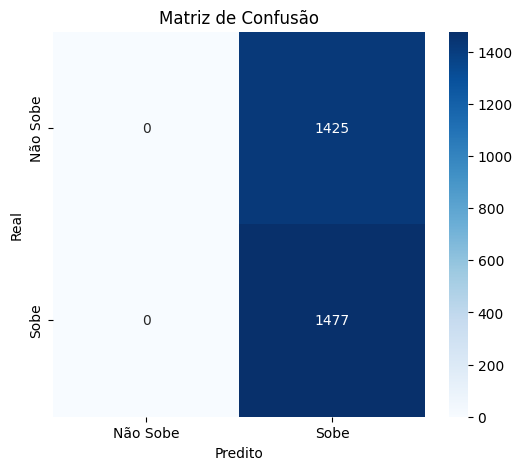

In [ ]:
print("\nMatriz de Confusão:")
# Um mapa de calor para visualizar a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobe', 'Sobe'], yticklabels=['Não Sobe', 'Sobe'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## PASSO 6: Visualizar o Treinamento

**Objetivo:** Plotar gráficos para ver se o modelo aprendeu bem ou se teve overfitting.

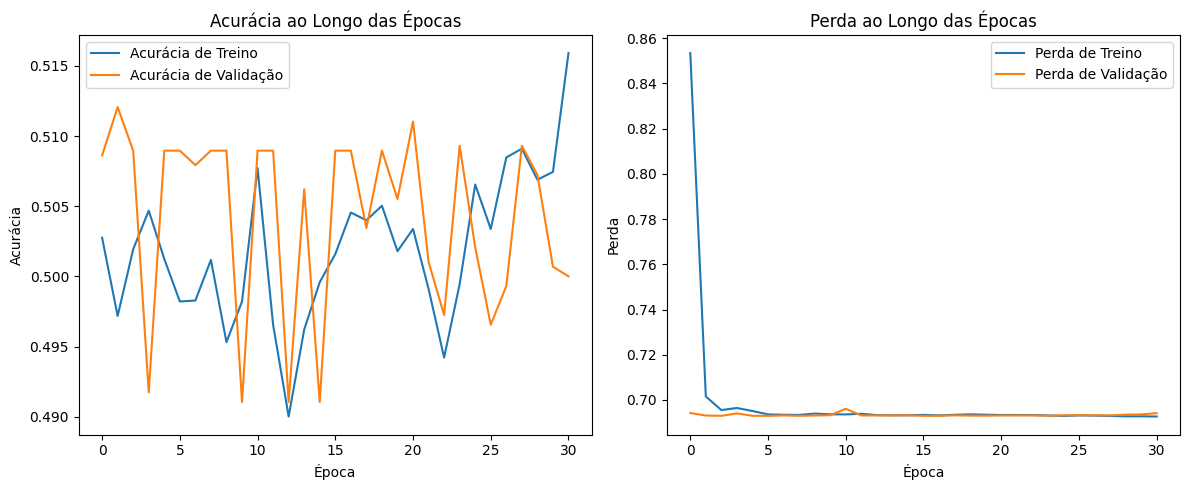

In [ ]:
plt.figure(figsize=(12, 5))

# Gráfico da Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico da Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

## PASSO 7: Salvar o Modelo

**Objetivo:** Salvar o modelo treinado e o normalizador para uso futuro.

In [ ]:
# Por enquanto não é necessário salvar o modelo
'''
MODEL_PATH = "mlp_basic_model.h5"
SCALER_PATH = "basic_scaler.pkl"

model.save(MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)

print(f"Modelo salvo em: {MODEL_PATH}")
print(f"Normalizador salvo em: {SCALER_PATH}")
'''

'\nMODEL_PATH = "mlp_basic_model.h5"\nSCALER_PATH = "basic_scaler.pkl"\n\nmodel.save(MODEL_PATH)\njoblib.dump(scaler, SCALER_PATH)\n\nprint(f"Modelo salvo em: {MODEL_PATH}")\nprint(f"Normalizador salvo em: {SCALER_PATH}")\n'

## Conclusão

### Já integrado:

1. **Carrega dados históricos**
2. **Prepara os dados**
3. **Constrói um MLP**
4. **Treina o modelo**
5. **Avalia o desempenho**
6. **Visualiza o treinamento**
7. **Salva o modelo**

### Próximos Passos:
- ENTENDER POR QUE O MODELO SÓ FALA QUE VAI SUBIR (ERA POR CAUSA DO MINMAXSCALER, POR TER MUITOS OUTLIERS ELE APERTAVA VALORES INTERMEDIARIOS EM UM INTERVALO MUITO PEQUENO... TROQUEI PARA STANDARDSCALER)
- Adicionar features técnicas, prepara-las e dar ao treino do modelo (não creio que esteja bom ainda)
- Implementar validação cruzada temporal (implementei)
- Testar diferentes janelas temporais

# Testes com outros modelos

**Meio freestyle considerando que os dados são reciclados e não adaptados**

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

print("--- Executando Testes alternativos com HistGradientBoosting ---")

# Crie e treine o modelo
rf_model = HistGradientBoostingClassifier(max_iter=100, random_state=42)
rf_model.fit(X_train, y_train)

# Faça previsões
rf_predictions = rf_model.predict(X_test)
# Avalie o resultado
print("\nRelatório de Classificação do HistGradientBoosting:")
print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

--- Executando Testes alternativos com HistGradientBoosting ---

Relatório de Classificação do HistGradientBoosting:
              precision    recall  f1-score   support

    Não Sobe       0.49      0.50      0.50      1425
        Sobe       0.51      0.50      0.51      1477

    accuracy                           0.50      2902
   macro avg       0.50      0.50      0.50      2902
weighted avg       0.50      0.50      0.50      2902



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

print("--- Executando Testes alternativos com RandomForest ---")

# Crie e treine o modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Faça previsões
rf_predictions = rf_model.predict(X_test)
# Avalie o resultado
print("\nRelatório de Classificação do RandomForest:")
print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

--- Executando Testes alternativos com RandomForest ---

Relatório de Classificação do RandomForest:
              precision    recall  f1-score   support

    Não Sobe       0.49      0.52      0.51      1425
        Sobe       0.51      0.48      0.50      1477

    accuracy                           0.50      2902
   macro avg       0.50      0.50      0.50      2902
weighted avg       0.50      0.50      0.50      2902



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

print("--- Executando Testes alternativos com GradientBoosting ---")

# Crie e treine o modelo
rf_model = GradientBoostingClassifier(
    n_estimators=200,         # Mais árvores pode melhorar, mas aumenta o tempo de treino
    learning_rate=0.05,       # Menor learning_rate pode melhorar generalização, mas exige mais árvores
    max_depth=4,              # Profundidade das árvores (3-5 é comum)
    subsample=0.8,            # Amostragem estocástica para robustez (0.8 é um bom começo)
    max_features='sqrt',      # Considera sqrt(n_features) em cada split (ajuda a evitar overfitting)
    random_state=42
)
rf_model.fit(X_train, y_train)

# Faça previsões
rf_predictions = rf_model.predict(X_test)
# Avalie o resultado
print("\nRelatório de Classificação do GradientBoosting:")
print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

--- Executando Testes alternativos com GradientBoosting ---

Relatório de Classificação do GradientBoosting:
              precision    recall  f1-score   support

    Não Sobe       0.50      0.52      0.51      1425
        Sobe       0.52      0.51      0.52      1477

    accuracy                           0.51      2902
   macro avg       0.51      0.51      0.51      2902
weighted avg       0.51      0.51      0.51      2902



In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

print("--- Executando Testes alternativos com StackingClassifier ---")

# Crie e treine o modelo
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        max_features='sqrt',
        random_state=42
    ))
]

rf_model = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced'),
    n_jobs=-1,
    passthrough=False
)
rf_model.fit(X_train, y_train)

# Faça previsões
rf_predictions = rf_model.predict(X_test)
# Avalie o resultado
print("\nRelatório de Classificação do StackingClassifier:")
print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

--- Executando Testes alternativos com StackingClassifier ---

Relatório de Classificação do StackingClassifier:
              precision    recall  f1-score   support

    Não Sobe       0.50      0.51      0.50      1425
        Sobe       0.51      0.50      0.51      1477

    accuracy                           0.51      2902
   macro avg       0.51      0.51      0.51      2902
weighted avg       0.51      0.51      0.51      2902



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report

print("--- Executando Testes alternativos com ExtraTreesClassifier ---")

# Crie e treine o modelo
rf_model = ExtraTreesClassifier(
    n_estimators=200,         # Número de árvores na floresta
    max_depth=6,              # Profundidade máxima das árvores (ajuda a evitar overfitting)
    max_features='sqrt',      # Número de features consideradas em cada split
    min_samples_split=5,      # Mínimo de amostras para dividir um nó interno
    min_samples_leaf=3,       # Mínimo de amostras em cada folha
    class_weight='balanced',  # Balanceia as classes automaticamente
    n_jobs=-1,                # Usa todos os núcleos disponíveis
    random_state=42           # Reprodutibilidade
)
rf_model.fit(X_train, y_train)

# Faça previsões
rf_predictions = rf_model.predict(X_test)
# Avalie o resultado
print("\nRelatório de Classificação do ExtraTreesClassifier:")
print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

--- Executando Testes alternativos com ExtraTreesClassifier ---

Relatório de Classificação do ExtraTreesClassifier:
              precision    recall  f1-score   support

    Não Sobe       0.49      0.49      0.49      1425
        Sobe       0.51      0.50      0.50      1477

    accuracy                           0.50      2902
   macro avg       0.50      0.50      0.50      2902
weighted avg       0.50      0.50      0.50      2902

